In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def plot_errors(train_data,test_data):
    test_diff = test_data['outofsample_error']
    train_diff = train_data['insample_error']
    
    test_plot = test_data[['date','spot_price','rho','v0']].copy()
    test_plot = test_plot.reset_index().set_index('date')
    test_plot['MAE'] = test_diff.resample('D').apply(compute_RMSE)
    test_plot['RMSE'] = test_diff.resample('D').apply(compute_RMSE)
    test_plot = test_plot.reset_index()
    test_plot = test_plot.drop_duplicates(subset=['date'],keep='last').set_index('date').drop(columns='calculation_date')
    
    train_plot = train_data[['date','spot_price','rho','v0']].copy()
    train_plot = train_plot.reset_index().set_index('date')
    train_plot['MAE'] = train_diff.resample('D').apply(compute_RMSE)
    train_plot['RMSE'] = train_diff.resample('D').apply(compute_RMSE)
    train_plot = train_plot.reset_index()
    train_plot = train_plot.drop_duplicates(subset=['date'],keep='last').set_index('date').drop(columns='calculation_date')

    
    trainx = pd.date_range(start=min(train_data.index),end=max(train_data.index),periods=train_plot.shape[0])
    testx = pd.date_range(start=min(test_data.index),end=max(test_data.index),periods=test_plot.shape[0])

    train_plot.index = trainx
    test_plot.index = testx
    
    
    fig,axs = plt.subplots(max(len(train_plot.columns),len(test_plot.columns)),figsize=(10,10),sharex=True)
    for i,col in enumerate(train_plot.columns):
        axs[i].plot(train_plot[col],color='green',label='in-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    for i,col in enumerate(test_plot.columns):
        axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    plt.show()

# loading model

In [3]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if f.find('.')==-1])
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_11_01 204910611379 bloomberg barriers
1     2024_11_01 205356527985 bloomberg asians
2     2024_11_05 184958719691 Oosterlee test
3     2024_11_07 124002946108 cboe spx asian
4     2024_11_07 170416543309 cboe spx barrier
5     2024_11_08 132233487632 cboe spx asian


In [4]:
selected_model = models.iloc[-1]
model_dir = os.path.join(models_dir,selected_model)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl')][0]
picke_dir = os.path.join(model_dir,pickle)
model = joblib.load(picke_dir)
model

{'raw_data':        spot_price  strike_price  days_to_maturity  n_fixings  \
 0          4038.0       2019.00                 7        1.0   
 1          4038.0       2019.00                 7        1.0   
 2          4038.0       3028.50                 7        1.0   
 3          4038.0       3028.50                 7        1.0   
 4          4038.0       4038.00                 7        1.0   
 ...           ...           ...               ...        ...   
 27920      5857.0       5856.50                84        1.0   
 27921      5857.0       7320.75                84        1.0   
 27922      5857.0       7320.75                84        1.0   
 27923      5857.0       8785.00                84        1.0   
 27924      5857.0       8785.00                84        1.0   
 
        fixing_frequency  past_fixings averaging_type     w  risk_free_rate  \
 0                     7             0      geometric  call        0.033849   
 1                     7             0     arith

In [5]:
model['train_data']

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,...,theta,rho,eta,v0,date,asian_price,observed_price,insample_target,insample_prediction,insample_error
0,4038.0,2019.0,7,1.0,7,0,geometric,call,0.033849,0.016191,...,1.550667e-08,-0.757195,1.033647,0.160861,2022-08-29,2017.675829,2017.675476,2017.675476,2002.902814,-14.772662
79,4038.0,4038.0,7,1.0,7,0,arithmetic,put,0.033849,0.016191,...,1.550667e-08,-0.757195,1.033647,0.160861,2022-08-29,55.836627,55.836368,55.836368,44.155656,-11.680712
78,4038.0,4038.0,7,1.0,7,0,arithmetic,call,0.033849,0.016191,...,1.550667e-08,-0.757195,1.033647,0.160861,2022-08-29,56.783855,56.785970,56.785970,55.419788,-1.366182
77,4038.0,4038.0,7,1.0,7,0,geometric,put,0.033849,0.016191,...,1.550667e-08,-0.757195,1.033647,0.160861,2022-08-29,56.364677,56.362147,56.362147,44.957996,-11.404151
76,4038.0,4038.0,7,1.0,7,0,geometric,call,0.033849,0.016191,...,1.550667e-08,-0.757195,1.033647,0.160861,2022-08-29,56.350733,56.348928,56.348928,56.037709,-0.311220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6583,3980.0,4975.0,28,1.0,28,0,geometric,put,0.045502,0.017174,...,1.132527e-01,-1.000000,0.627681,0.021981,2023-03-21,987.834451,987.833384,987.833384,964.522315,-23.311069
6582,3980.0,3980.0,28,1.0,28,0,arithmetic,call,0.045502,0.017174,...,1.132527e-01,-1.000000,0.627681,0.021981,2023-03-21,42.796526,42.796332,42.796332,41.385524,-1.410808
6581,3980.0,3980.0,28,1.0,28,0,geometric,call,0.045502,0.017174,...,1.132527e-01,-1.000000,0.627681,0.021981,2023-03-21,42.553674,42.551050,42.551050,40.809853,-1.741197
6603,3980.0,3980.0,84,3.0,28,0,geometric,call,0.045502,0.017174,...,1.132527e-01,-1.000000,0.627681,0.021981,2023-03-21,81.452863,81.454382,81.454382,74.144081,-7.310301


In [6]:
print('model attributes:\n')
for k in model.keys():
    print(k)

model attributes:

raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
pipeline
model
model_fit
dnn_runtime
numerical_scaler
dnn_params
transformers
regressor
dnn_pipeline


In [7]:
for col in model['feature_set']:
    print(f"{col.replace("_"," ")}:",f"\n{model['test_data'][col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()

spot price: 
0      3917.0
1      3964.0
2      3976.0
3      3989.0
4      4001.0
        ...  
202    5728.0
203    5729.0
204    5785.0
205    5857.0
206    5863.0
Name: spot_price, Length: 207, dtype: float64

strike price: 
0       1958.0
1       1982.0
2       1988.0
3       1994.0
4       2000.0
         ...  
1004    8592.0
1005    8593.0
1006    8677.0
1007    8785.0
1008    8794.0
Name: strike_price, Length: 1009, dtype: float64

days to maturity: 
0     7
1    28
2    84
Name: days_to_maturity, dtype: int64

fixing frequency: 
0     7
1    28
2    84
Name: fixing_frequency, dtype: int64

past fixings: 
0    0
Name: past_fixings, dtype: int64

risk free rate: 
0      0.038915
1      0.039349
2      0.039697
3      0.040096
4      0.040569
         ...   
150    0.054316
151    0.054390
152    0.054494
153    0.054500
154    0.054513
Name: risk_free_rate, Length: 155, dtype: float64

dividend rate: 
0      0.012687
1      0.012830
2      0.012841
3      0.012912
4      0.01297

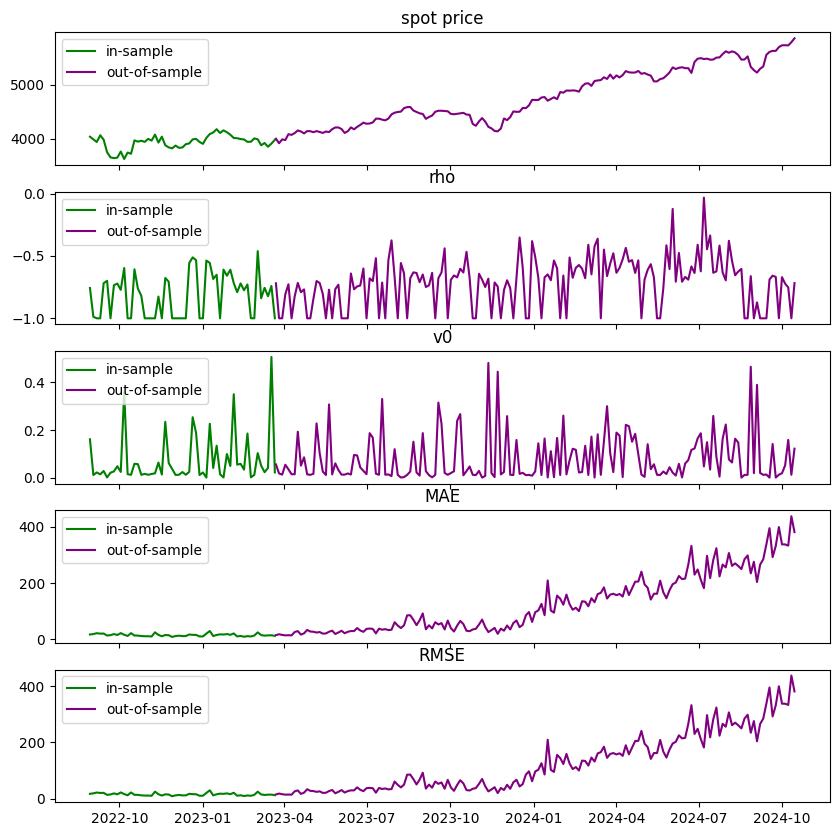

In [8]:
train_data = model['train_data'].copy()
test_data = model['test_data'].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed')
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed')
test_data = test_data.set_index('calculation_date').sort_index()
train_data = train_data.set_index('calculation_date').sort_index()
plot_errors(train_data,test_data)

# retraining

In [9]:
from convsklearn import convsklearn
help(convsklearn)

Help on class convsklearn in module convsklearn.convsklearn:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object




training on 10699 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 0.6633751392364502

in sample:
     RMSE: 11.160691686314673
     MAE: 8.13690949331898

out of sample:
     RMSE: 166.2872384998292
     MAE: 119.57169482818827


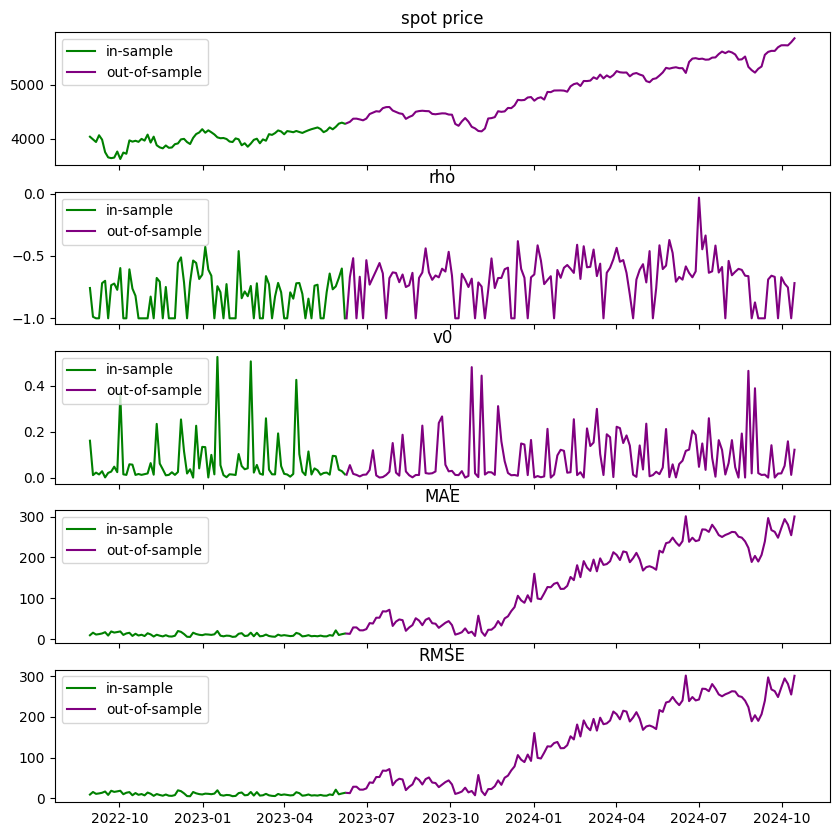



training on 14243 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 1.3503098487854004

in sample:
     RMSE: 12.232138504739744
     MAE: 9.188120484957178

out of sample:
     RMSE: 52.11337893996745
     MAE: 39.95589101465329


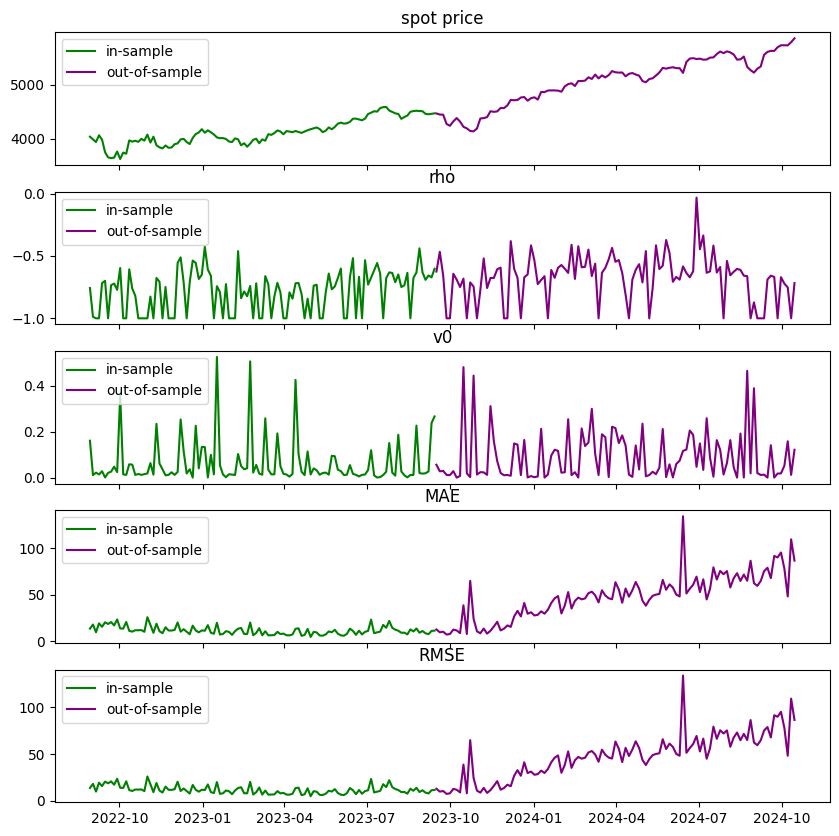



training on 18013 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 1.9225735664367676

in sample:
     RMSE: 8.51106152015844
     MAE: 6.141533530310094

out of sample:
     RMSE: 83.61726370581142
     MAE: 50.9326968678519


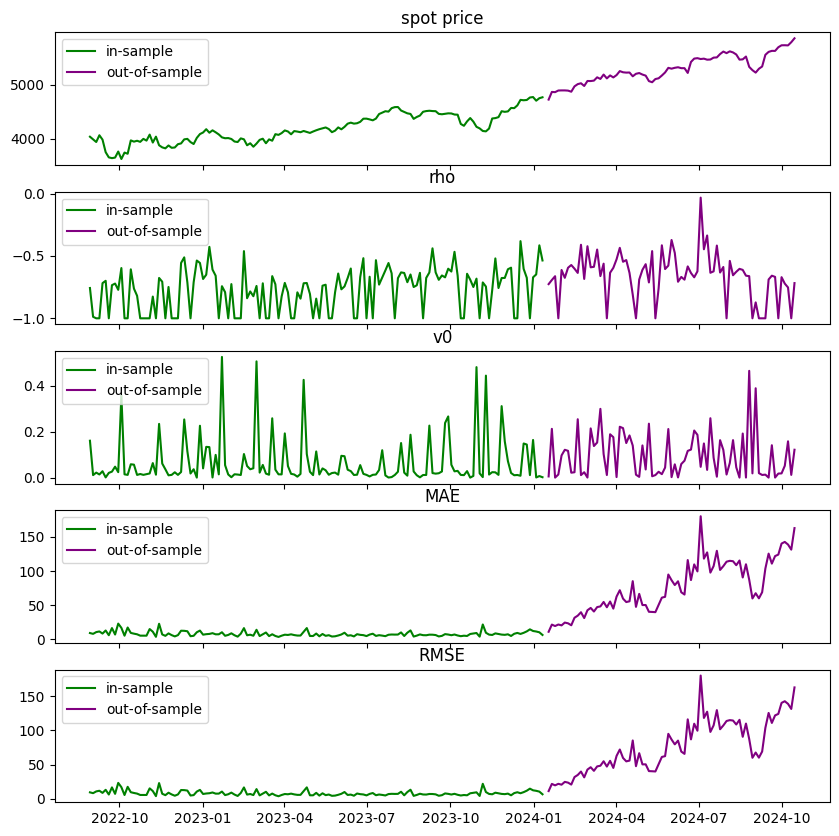



training on 22240 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 2.656709909439087

in sample:
     RMSE: 9.434446090771814
     MAE: 6.778195200295153

out of sample:
     RMSE: 25.04625366318497
     MAE: 17.74888877562305


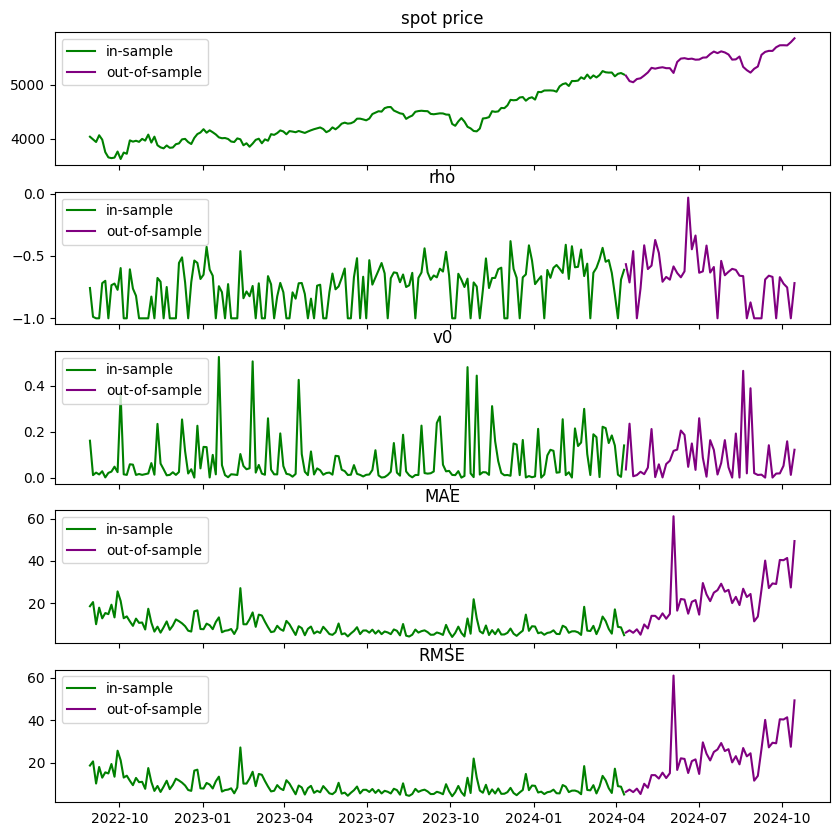



training on 25921 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 2.677279233932495

in sample:
     RMSE: 8.856723001788133
     MAE: 5.614286254785293

out of sample:
     RMSE: 16.076150218956357
     MAE: 8.29341992972138


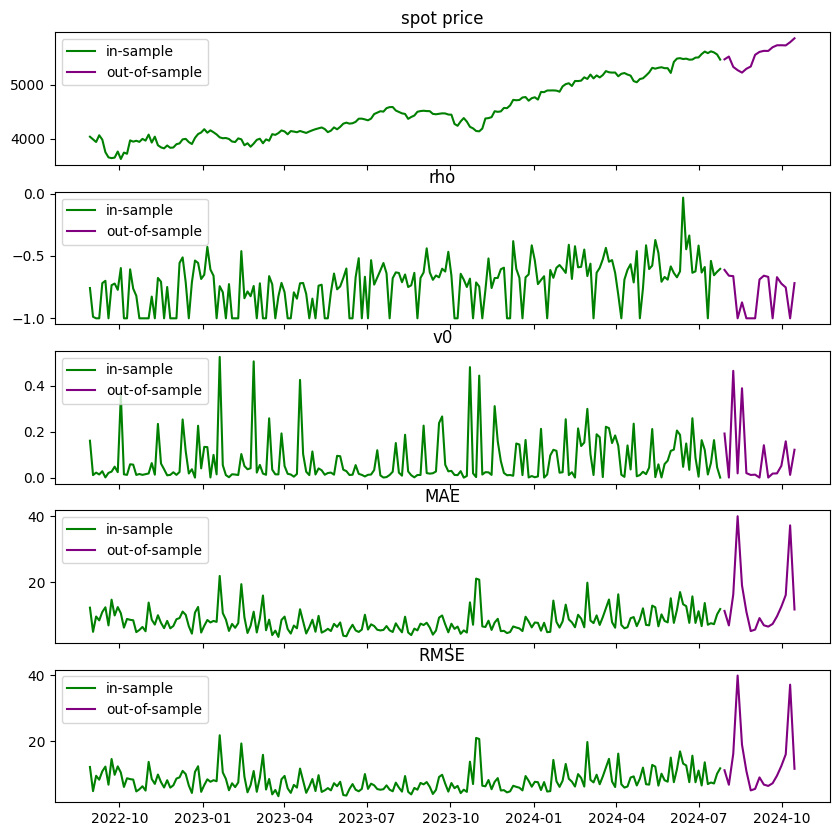



training on 27925 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 2.778402090072632


In [10]:
retraining_frequency = 30 #days
test_dates = model['test_dates']
full_dataset = model['dataset']
models = {}
for i, date in enumerate(test_dates):
    development_dates = pd.concat([model['development_dates'],test_dates[:(i+1)*retraining_frequency]])
    subset_test_dates = test_dates[~test_dates.isin(development_dates)]
    if development_dates.shape == 0:
        break
    try:
        retrainer = convsklearn()
        retrainer.load_data(full_dataset)
        retrainer.preprocess_data(development_dates, subset_test_dates,plot=False)
        retrainer.run_dnn()
        retrainer.test_prediction_accuracy()
        models[date] = retrainer.__dict__
        plot_errors(retrainer.train_data.set_index('calculation_date'),retrainer.test_data.set_index('calculation_date'))
        print()
    except Exception as e:
        if str(e).find('Found array with 0 sample(s)')==-1:
            print(e)
        break

In [11]:
pd.concat([model['development_dates'],model['test_dates']])

0      2022-08-29
1      2022-08-30
2      2022-09-07
3      2022-09-09
4      2022-09-13
          ...    
217    2024-09-24
218    2024-10-07
219    2024-10-08
220    2024-10-09
221    2024-10-14
Length: 222, dtype: object

In [12]:
for k,m in models.items():
    print(k)
    print(m['test_data'].iloc[:,-4:].describe())
    print()
    print('%'*20)

2023-03-22
       observed_price  outofsample_target  outofsample_prediction  \
count    17226.000000        17226.000000            17226.000000   
mean      1403.142161         1403.142161             1465.762058   
std        931.191079          931.191079              875.907620   
min         42.630479           42.630479               17.014632   
25%       1024.497810         1024.497810             1031.245775   
50%       1288.570899         1288.570899             1581.302065   
75%       2253.192788         2253.192788             2240.907530   
max       2931.603096         2931.603096             2745.482460   

       outofsample_error  
count       17226.000000  
mean           62.619897  
std           154.050550  
min          -276.249310  
25%           -27.633584  
50%            21.057108  
75%           148.815460  
max           544.151074  

%%%%%%%%%%%%%%%%%%%%
2023-03-24
       observed_price  outofsample_target  outofsample_prediction  \
count    13682.000000 